In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimBF4_PR import configuration
data = pd.read_csv('R125_bmimBF4.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['bmimBF4', 'R125'].fix(0.57152)
m.fs.properties.PR_kappa_A['R125', 'bmimBF4'].fix(0.06453)
m.fs.properties.PR_kappa_B['bmimBF4', 'R125'].fix(0.0)
m.fs.properties.PR_kappa_B['R125', 'bmimBF4'].fix(0.0)

# Initialize the flash unit
# m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].unfix()



In [4]:
bmim = np.linspace(data["x_bmimBF4"].iloc[6], data["x_bmimBF4"].iloc[0], 10)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R125_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"] == m.fs.liq)

for i in range(len(bmim)):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
    b = 1-(bmim[i])
    print(b)
    P0[i] = -3697933.78*b**2 + 3954496.68*b + 28280.66

    print(P0[i])

    m.fs.F101.inlet.temperature.fix(298.15)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].fix(bmim[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(298.15)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x1[i] = "NaN"
            P[i] = "NaN"



0
0.378
994704.8348184802
1
0.3368888888888889
940812.8996776455
2
0.2957777777777778
874421.0352903419
3
0.2546666666666667
795529.2416565691
4
0.2135555555555555
704137.5187763269
5
0.1724444444444444
600245.8666496157
6
0.1313333333333333
483854.2852764355
7
0.0902222222222222
354962.7746567861
8
0.049111111111111105
213571.33479066766
9
0.008000000000000007
59679.96567808003


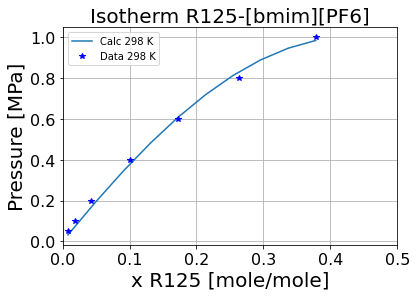

In [5]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

    
plt.plot(R125_x1,P1,"-",label="Calc 298 K")  
plt.plot(data["x_R125"][0:8],data["pressure"][0:8]/1e6,"*",color='b',label="Data 298 K")  
plt.title('Isotherm R125-[bmim][PF6]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R125 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.ylim(0,1.110000)
plt.xlim(0,0.5)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R125-[bmim][PF6]_bin_noT.png', bbox_inches='tight',dpi=300)
plt.show()


In [6]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')

In [7]:
print(P)

[984244.76236286 946251.77435139 889077.36188779 812976.04803183
 718834.75250148 608007.95630637 482143.21512302 343026.09580117
 192459.33958532  32178.59394527]


In [8]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty :  29.405 : False : (None, None)
    Pressure Change : -27501. : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                             Inlet  Vapor Outlet  Liquid Outlet
    flow_mol                1.0000      0.10081      0.89919   
    mole_frac_comp bmimBF4 0.89200   1.0000e-08      0.99200   
    mole_frac_comp R125    0.10800       1.0000    0.0080000   
    temperature             298.15       298.15       298.15   
    pressure                59680.       32179.       32179.   
